### Analysis of Purchase Data 

Let's take a look at purchase data from some ecommerce companies

In [87]:
import pandas as pd
import numpy as np
import datetime
from scipy.stats import chi2_contingency, beta, lognorm, norm, invgamma
from IPython.display import Image

Here is a cool dataset: https://www.kaggle.com/benroshan/ecommerce-data?select=Order+Details.csv

<AxesSubplot:ylabel='Frequency'>

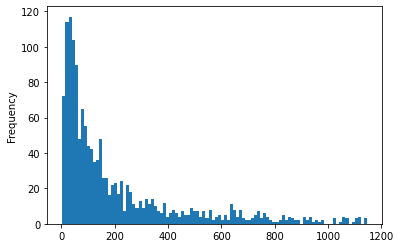

In [88]:
data = pd.read_csv('csv/orders_shop_1.csv')
data['Amount'][data['Amount'] < data.quantile(0.95)['Amount']].plot.hist(bins=100)

<AxesSubplot:ylabel='Frequency'>

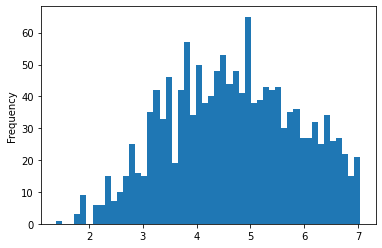

In [89]:
prices = data['Amount'][
            (data['Amount'] < data.quantile(0.95)['Amount']) & 
            (data['Amount'] > 0)]
np.log(prices).plot.hist(bins=50)

Another cool dataset: https://www.kaggle.com/zusmani/pakistans-largest-ecommerce-dataset

<AxesSubplot:ylabel='Frequency'>

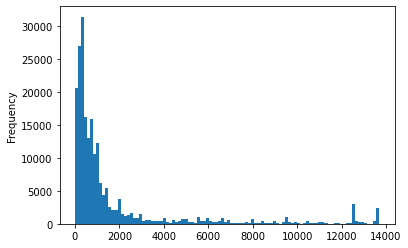

In [90]:
data = pd.read_csv('csv/orders_shop_2.csv', low_memory=False)
data = data[data['status']=='complete']
data['price'][data['price'] < data.quantile(0.9)['price']].plot.hist(bins=100)

In both cases, purchase data is can be modeled by a **log normal distribution**. A lot of prices are low, a few prices are high. The log of these prices follow a normal distribution for the most part

<AxesSubplot:ylabel='Frequency'>

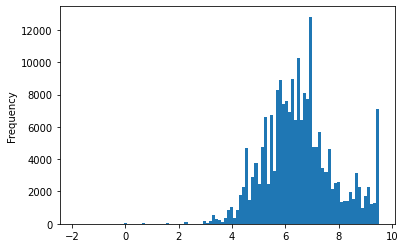

In [91]:
prices = data['price'][
            (data['price'] < data.quantile(0.9)['price']) & 
            (data['price'] > 0)]
np.log(prices).plot.hist(bins=100)

### Create Distributions

In [92]:
data = pd.read_csv('csv/orders_shop_1.csv')
data['price'] = data['Amount']
data = data[
            (data['price'] < data.quantile(0.95)['price']) & 
            (data['price'] > 0)]

In [93]:
# data = pd.read_csv('data/orders_shop_2.csv', low_memory=False)
# data = data[(data['status']=='complete') & 
#             (data['price'] > 0) & 
#             (data['price'] < data.quantile(0.9)['price'])]

In [94]:
data = data.reset_index().drop('index', axis=1)
sigma, loc, scale = lognorm.fit(data['price'], floc=0)
control_price_sampler = lognorm(sigma, loc, scale)

In [95]:
sigma, loc, scale

(1.2003967898192194, 0.0, 107.68628337370997)

<AxesSubplot:ylabel='Frequency'>

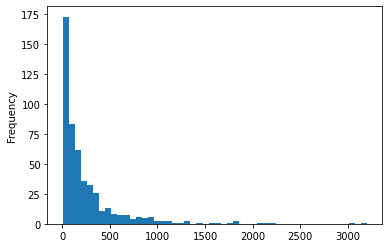

In [96]:
pd.Series(control_price_sampler.rvs(500)).plot.hist(bins=50)

In [97]:
price_change_distribution = norm(loc=25, scale=5)
price_changes = price_change_distribution.rvs(data['price'].shape[0])
treatment_prices = data['price'] + pd.Series(price_changes)
treatment_prices = treatment_prices[treatment_prices > 0] # For valid lognormal fitting

In [98]:
sigma, loc, scale = lognorm.fit(treatment_prices, floc=0)
treatment_price_sampler = lognorm(sigma, loc, scale)

In [99]:
sigma, loc, scale

(0.9304919292889252, 0.0, 148.00719270640306)

<AxesSubplot:ylabel='Frequency'>

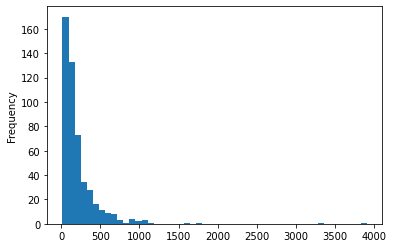

In [100]:
pd.Series(treatment_price_sampler.rvs(500)).plot.hist(bins=50)

### Create Dataset

In [101]:
df = pd.read_csv('data/ab_data.csv')

## Remove users exposed to both groups
counter = df['user_id'].value_counts()
valid_users = pd.DataFrame(counter[counter == 1].index, columns=['user_id'])
df = df.merge(valid_users, on=['user_id'])
df['week'] = df['timestamp'].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f').isocalendar()[1])

## Get stats
start_time = datetime.datetime.strptime(df['timestamp'].min(), '%Y-%m-%d %H:%M:%S.%f')
end_time = datetime.datetime.strptime(df['timestamp'].max(), '%Y-%m-%d %H:%M:%S.%f')
data_duration = (end_time - start_time).days

print(f"Number of unique users in experiment: {df['user_id'].nunique()}")
print(f"Data collected for {data_duration} days")
print(f"Landing pages to compare: {df['landing_page'].unique().tolist()}")
print(f"Percentage of users in control: {round(df[df['group']=='control'].shape[0] * 100 / df.shape[0])}%")

Number of unique users in experiment: 286690
Data collected for 21 days
Landing pages to compare: ['old_page', 'new_page']
Percentage of users in control: 50%


Generate prices using the 2 lognormal distributions we created

In [102]:
def get_purchase_data(exposure):
    if exposure['group'] == 'treatment':
        return treatment_price_sampler.rvs()
    return control_price_sampler.rvs()

df['price'] = df.apply(get_purchase_data, axis=1).astype(int)
df = df[df['price'] > 0]

In [103]:
df.sample(2)

,user_id,timestamp,group,landing_page,converted,week,price
192899,867946,2017-01-08 23:57:17.528954,control,old_page,0,1,581
26510,679598,2017-01-14 05:05:30.293413,control,old_page,0,2,409


In [104]:
df.to_csv('data/dataset.csv')

### Bayes Math

Goal of Bayesian Testing is find the Posterior 

$$P(\theta | \text{ data })$$

$\theta$ represents the parameters of the distribution. For a normal distribution
$$
\theta = \mu, \sigma^2
$$

Thus, we want to find this joint posterior distribution: 

$$
P(\mu, \sigma^2 | \text{ data })
$$

From bayes theorem:

$$
P(\mu, \sigma^2 | \text{ data }) = P(\sigma^2 | \text{data}) \times P(\mu | \sigma^2, \text{data})
$$

[The book](https://users.aalto.fi/~ave/BDA3.pdf) on bayesian analysis shows with some simplifications that:

$$
\sigma^2 \text{~} \text{Inv-}\Gamma(\frac{v_0}{2},\frac{v_0\sigma_0^2}{2}) \\
\mu | \sigma^2 \text{~}      N(\mu_0, \frac{\sigma^2}{k_0})
$$

The hyperparameters with suffix 0 are prior constants (provided before the experiment)

Chapter 3, Page 68 explains how to determine the **posterier values** of these hyperparameters

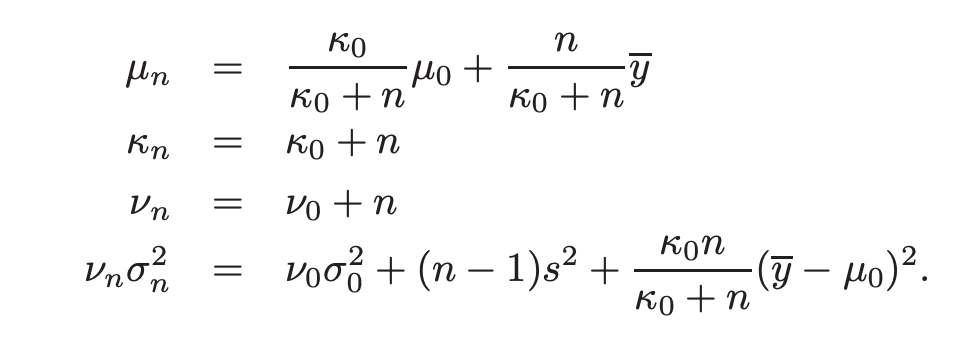

In [105]:
Image(filename='../mics/continuous_equations.png') 

So the steps are:
1. Sample the $\sigma^2$ values from the inverse chi sq distribution
2. Use this to sample the means $\mu$ from the normal distribution

Let's code the math out. The following function is borrowed from [here](https://python.hotexamples.com/site/file?hash=0x624bd5b7fcf7c43ba274af03eb71a2c306362a30e625180419b8ff8db1da54af&fullName=wmf-master/bayesian_normal.py&project=KoLogicDev/wmf)

In [106]:
def draw_mus_and_sigmas(data, m0, k0, s_sq0, v0, n_samples=10000):
    """
    Sample mus (list) and sigma_squares (list) that are effectively
    sampled from the posterior normal distribtution
    """

    N = np.size(data) # number of samples
    the_mean = np.mean(data) # find the mean of the data
    SSD = sum( (data - the_mean)**2 ) # sum of squared differences between data and mean
    
    # 1) Sample the variances from an inverse gamma (params: alpha, beta)
    kN = float(k0 + N)
    mN = (k0/kN)*m0 + (N/kN)*the_mean
    vN = v0 + N
    vN_times_s_sqN = v0*s_sq0 + SSD + (N*k0*(m0-the_mean)**2)/kN
    alpha = vN/2
    beta = vN_times_s_sqN/2

    # NOTE: if X ~ inv-gamma(a,1) then b*X ~ inv-gamma(a,b)
    sig_sq_samples = beta*invgamma.rvs(alpha,size=n_samples)

    # 2) Sample means from a normal conditioned on the drawn sigmas (params: mean_norm, var_norm)
    mean_norm = mN
    var_norm = np.sqrt(sig_sq_samples/kN)
    mu_samples = norm.rvs(mean_norm,scale=var_norm,size=n_samples)

    # 3) return the mu_samples and sig_sq_samples
    return mu_samples, sig_sq_samples

Let's use this for the log normal distribution

If 
$$
X \text{~} N(\mu_x, \sigma_x^2)
$$ 

then

$$
e^X \text{~ logN}\bigg(e^{\mu_x + \frac{\sigma^2_x}{2}},e^{2\mu_x + \sigma^2_x}(e^{\sigma^2_x}-1) \bigg)
$$

The following function returns data sampled from a log normal distribution

In [140]:
def draw_log_normal_means(data, m0, k0, s_sq0, v0, n_samples):
    normal_data = np.log(data)
    mu_samples, sig_sq_samples = draw_mus_and_sigmas(normal_data, m0, k0, s_sq0, v0, n_samples)
    log_normal_mu_samples = np.exp(mu_samples + sig_sq_samples/2)
    return log_normal_mu_samples

In [151]:
NUM_WEEKS = 3
prior = df[(df['group'] == 'control') & (df['week']==1)]
experiment = df[(df['week'] > 1) & (df['week'] <= NUM_WEEKS)]

In [152]:
# Define priors (sell thru)
prior_samples = [prior['converted'].sample(1000).mean() for i in range(1000)] # Conversion Rates
prior_alpha, prior_beta, _, _ = beta.fit(prior_samples, floc=0, fscale=1)

In [153]:
# Define priors (prices)
prior_conversions = prior[prior['converted']==1]
prior_samples = [prior_conversions.sample(1000).mean() for i in range(1000)]
prior_sigma, prior_loc, prior_scale = lognorm.fit(prior_samples, floc=0)

In [154]:
# Posteriors
treatment = experiment[experiment['group'] == 'treatment']
control = experiment[experiment['group'] == 'control']

treatment_converted = treatment['converted'].sum()
treatment_non_converted = treatment['converted'].count() - treatment['converted'].sum()
control_converted = control['converted'].sum()
control_non_converted = control['converted'].count() - control['converted'].sum()

# Update Prior parameters with experiment conversion rates
posterior_control = beta(prior_alpha + control_converted, prior_beta + control_non_converted)
posterior_treatment = beta(prior_alpha + treatment_converted, prior_beta + treatment_non_converted)

# Sample from Posteriors
control_conversion_samples = posterior_control.rvs(1000)
treatment_conversion_samples = posterior_treatment.rvs(1000)

In [155]:
control_converted = control[control['converted']==1]
treatment_converted = treatment[treatment['converted']==1]

m0 = np.log(prior_scale) # Where we think the mean of the posterior normal is
k0 = 1.
s_sq0 = 1.
v0 = 1.

treatment_price_samples = draw_log_normal_means(treatment_converted['price'],m0,k0,s_sq0,v0,n_samples=1000)
control_price_samples = draw_log_normal_means(control_converted['price'],m0,k0,s_sq0,v0,n_samples=1000)

In [156]:
# Get expected price E(x) = xP(x)
treatment_expected_price_samples = treatment_conversion_samples*treatment_price_samples
control_expected_price_samples = control_conversion_samples*control_price_samples

In [157]:
lift = pd.Series((treatment_expected_price_samples - control_expected_price_samples)/control_expected_price_samples)
lift = lift.value_counts().sort_index().cumsum() / len(lift)
lift = lift.reset_index()
lift.columns = ['Price Lift', 'Cumulative Probability']

In [158]:
lift

,Price Lift,Cumulative Probability
0,-0.023751,0.001
1,-0.013691,0.002
2,-0.012459,0.003
3,-0.012125,0.004
4,-0.010679,0.005
...,...,...
995,0.109922,0.996
996,0.110070,0.997
997,0.111081,0.998
998,0.111743,0.999


In [159]:
out_df = lift[lift['Price Lift'] >= 0]
lift = round(out_df['Cumulative Probability'].iloc[0], 2)*100
out_text = f'{round(100-lift, 2)}%'

In [160]:
print(f"{out_text} chance that the lift is price is ${round(treatment['price'].mean() - control['price'].mean(), 2)}")

98.0% chance that the lift is price is $7.66
